In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import sys
import time

In [2]:
# import pytorch modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [3]:
# plotting
sys.path.insert(0,'..')
from utilz import plot_stroke

In [4]:
# find gpu
cuda = torch.cuda.is_available()

In [5]:
# hyperparamters
timesteps = 300
num_clusters = 20
cell_size = 400
nlayers = 2
bsize = 600
init_lr = 1E-3

In [6]:
# prepare training data
train_data = np.load('train_data.npy')
train_data = torch.from_numpy(train_data)
if cuda:
    train_data = train_data.cuda()
    train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=bsize, shuffle=True)
    
# prepare validation data
validation_data = np.load('validation_data.npy')
validation_data = torch.from_numpy(validation_data)
if cuda:
    validation_data = validation_data.cuda()

In [7]:
# 2-layer lstm with mixture of gaussian parameters as outputs
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size = 3, hidden_size = cell_size, num_layers = nlayers, batch_first=True)
        self.linear1 = nn.Linear(cell_size, 1+ num_clusters*6)
        self.tanh = nn.Tanh()
        
    def forward(self, x, prev):
        timesteps = x.shape[1]
        h, (h_n, c_n) = self.lstm(x, prev)
        params = self.linear1(h)
        weights = F.softmax(params.narrow(-1, 0, num_clusters), dim=-1)
        mu_1 = params.narrow(-1, num_clusters, num_clusters)
        mu_2 = params.narrow(-1, 2*num_clusters, num_clusters)
        log_sigma_1 = params.narrow(-1, 3*num_clusters, num_clusters)
        log_sigma_2 = params.narrow(-1, 4*num_clusters, num_clusters)
        p = self.tanh(params.narrow(-1, 5*num_clusters, num_clusters))
        end = F.sigmoid(params.narrow(-1, 6*num_clusters, 1))
        
        return end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, (h_n, c_n)

In [8]:
# training objective
def log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, x):
    timesteps = x.shape[1]
    x_0 = x.narrow(-1,0,1)
    x_1 = x.narrow(-1,1,1)
    x_2 = x.narrow(-1,2,1)
    end_loglik = (x_0*end + (1-x_0)*(1-end)).log()
    const = 1E-20
    z = (x_1 - mu_1)**2/(log_sigma_1.exp()**2+const)\
        + ((x_2 - mu_2)/(log_sigma_2.exp()+const))**2 \
        - 2*p*(x_1-mu_1)*(x_2-mu_2)/((log_sigma_1 + log_sigma_2).exp()+const)
    mog_lik1 = -log_sigma_1 - log_sigma_2 - 0.5*(1-p**2).log()
    mog_lik2 = (z.log()-(2*(1-p**2)).log()).exp()
    mog_lik = (weights.log() + (mog_lik1 - mog_lik2)).exp().sum(dim=-1)
    return end_loglik.sum() + (mog_lik+const).log().sum()

In [9]:
def decay_learning_rate(optimizer, decay = 1.05):
    state_dict = optimizer.state_dict()
    lr = state_dict['param_groups'][0]['lr']
    lr /= decay
    for param_group in state_dict['param_groups']:
        param_group['lr'] = lr
    optimizer.load_state_dict(state_dict)
    return optimizer

In [10]:
def save_checkpoint(epoch, model, validation_loss, optimizer, filename='best.pt'):
    checkpoint=({'epoch': epoch+1,
    'model': model.state_dict(),
    'validation_loss': validation_loss,
    'optimizer' : optimizer.state_dict()
    })
    torch.save(checkpoint, filename)

In [10]:
model = LSTM()
if cuda:
    model = model.cuda()

In [13]:
epochs = 30
optimizer = optim.Adam([
                {'params':model.parameters()},
            ], lr=init_lr)
state = torch.load('epoch_30_2.pt')
model.load_state_dict(state['model'])
state_opt = state['optimizer'] 
# # for param_group in state_opt['param_groups']:
# #         param_group['lr'] = 0.0005
optimizer.load_state_dict(state_opt)



In [51]:
# training
h_init, c_init = torch.zeros((2,bsize,cell_size)), torch.zeros((2,bsize,cell_size))
zero_tensor = torch.zeros((bsize, 1, 3))

h_init2, c_init2 = torch.zeros((2, validation_data.size()[0],cell_size)),\
                    torch.zeros((2,validation_data.size()[0],cell_size))
zero_tensor2 = torch.zeros((validation_data.size()[0], 1, 3))
if cuda:
    h_init = h_init.cuda()
    c_init = c_init.cuda()
    zero_tensor = zero_tensor.cuda()
    h_init2 = h_init2.cuda()
    c_init2 = c_init2.cuda()
    zero_tensor2 = zero_tensor2.cuda()
h_init, c_init = Variable(h_init), Variable(c_init)
h_init2, c_init2 = Variable(h_init2), Variable(c_init2)

# prepare validation data
step_back2 = torch.cat([zero_tensor2, validation_data.narrow(1,0,timesteps-1)], 1)
x2 = Variable(step_back2, requires_grad=False)
y2 = Variable(validation_data, requires_grad = False)

# t_loss = []
# v_loss = []
# best_validation_loss = 1E10

start_time = time.time()
# for epoch in range(epochs):
for epoch in range(60,80):
    train_loss =0
    for batch_idx, data in enumerate(train_loader):
        step_back = torch.cat([zero_tensor, data.narrow(1,0,timesteps-1)], 1)
        x = Variable(step_back, requires_grad=False)
        optimizer.zero_grad()
        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev= model(x, (h_init, c_init))
        y = Variable(data, requires_grad=False)
        loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))
        
        

    print('====> Epoch: {} Average train loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))
    t_loss.append(train_loss / len(train_loader.dataset))
    
    # validation
    end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p , prev= model(x2, (h_init2, c_init2))
    loss = -log_likelihood(end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, y2)
    validation_loss = loss.data[0]
    print('====> Epoch: {} Average validation loss: {:.4f}'.format(
          epoch+1, validation_loss / validation_data.size()[0]))
    v_loss.append(validation_loss)

    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        save_checkpoint(epoch, model, validation_loss, optimizer)
    
    # learning rate annealing
    optimizer = decay_learning_rate(optimizer, 1.01)
    
    # checkpoint model and training
    #if (epochs+1)%5 == 0:
    filename = 'epoch_{}_2.pt'.format(epoch+1)
    save_checkpoint(epoch, model, validation_loss, optimizer, filename)

    # testing checkpoints
    state = torch.load(filename)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    
    print('wall time: {}s'.format(time.time()-start_time))

Train Epoch: 61 [0/54000 (0%)]	Loss: -693.565208
Train Epoch: 61 [6000/54000 (11%)]	Loss: -690.159115
Train Epoch: 61 [12000/54000 (22%)]	Loss: -688.663333
Train Epoch: 61 [18000/54000 (33%)]	Loss: -688.561094
Train Epoch: 61 [24000/54000 (44%)]	Loss: -681.061094
Train Epoch: 61 [30000/54000 (56%)]	Loss: -685.853490
Train Epoch: 61 [36000/54000 (67%)]	Loss: -688.420990
Train Epoch: 61 [42000/54000 (78%)]	Loss: -695.576771
Train Epoch: 61 [48000/54000 (89%)]	Loss: -681.150833
====> Epoch: 61 Average train loss: -686.6256
====> Epoch: 61 Average validation loss: -558.4615
wall time: 129.57238101959229s
Train Epoch: 62 [0/54000 (0%)]	Loss: -685.171667
Train Epoch: 62 [6000/54000 (11%)]	Loss: -690.263750
Train Epoch: 62 [12000/54000 (22%)]	Loss: -683.801719
Train Epoch: 62 [18000/54000 (33%)]	Loss: -685.001354
Train Epoch: 62 [24000/54000 (44%)]	Loss: -685.846667
Train Epoch: 62 [30000/54000 (56%)]	Loss: -698.135208
Train Epoch: 62 [36000/54000 (67%)]	Loss: -689.047917
Train Epoch: 62 [420

Train Epoch: 74 [36000/54000 (67%)]	Loss: -714.033646
Train Epoch: 74 [42000/54000 (78%)]	Loss: -706.295000
Train Epoch: 74 [48000/54000 (89%)]	Loss: -713.561198
====> Epoch: 74 Average train loss: -711.7531
====> Epoch: 74 Average validation loss: -538.6097
wall time: 1817.3365190029144s
Train Epoch: 75 [0/54000 (0%)]	Loss: -713.065469
Train Epoch: 75 [6000/54000 (11%)]	Loss: -713.927500
Train Epoch: 75 [12000/54000 (22%)]	Loss: -711.475990
Train Epoch: 75 [18000/54000 (33%)]	Loss: -712.174219
Train Epoch: 75 [24000/54000 (44%)]	Loss: -706.531406
Train Epoch: 75 [30000/54000 (56%)]	Loss: -709.738177
Train Epoch: 75 [36000/54000 (67%)]	Loss: -705.682969
Train Epoch: 75 [42000/54000 (78%)]	Loss: -714.695208
Train Epoch: 75 [48000/54000 (89%)]	Loss: -718.432240
====> Epoch: 75 Average train loss: -711.5116
====> Epoch: 75 Average validation loss: -535.1517
wall time: 1947.1157627105713s
Train Epoch: 76 [0/54000 (0%)]	Loss: -708.195729
Train Epoch: 76 [6000/54000 (11%)]	Loss: -713.926146


In [14]:
def generate_unconditionally(model, steps=700, random_seed=1):
    torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h_init, c_init = torch.zeros((2,1,cell_size)), torch.zeros((2,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h_init = h_init.cuda()
        c_init = c_init.cuda()
    x = Variable(zero_tensor)
    h_init, c_init = Variable(h_init), Variable(c_init)
    prev = (h_init, c_init)

    record = []
    # greedy but not the right generation
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev = model(x, prev)
        prob_end = end.data[0][0][0]
        sample_end = np.random.binomial(1,prob_end)
        
        sample_index = np.random.choice(range(20),p = weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])
        v1 = log_sigma_1.exp().data[0][0][sample_index]**2
        v2 = log_sigma_2.exp().data[0][0][sample_index]**2
        c = p.data[0][0][sample_index]*log_sigma_1.exp().data[0][0][sample_index]*log_sigma_2.exp().data[0][0][sample_index]
        cov = np.array([[v1,c],[c,v2]])
        sample_point = np.random.multivariate_normal(mu, cov)
        out = np.insert(sample_point,0,sample_end)
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [53]:
def greedy_generate(steps=700):
    #torch.manual_seed(random_seed)
    zero_tensor = torch.zeros((1,1,3))
    h_init, c_init = torch.zeros((2,1,cell_size)), torch.zeros((2,1,cell_size))
    if cuda:
        zero_tensor = zero_tensor.cuda()
        h_init = h_init.cuda()
        c_init = c_init.cuda()
    x = Variable(zero_tensor)
    h_init, c_init = Variable(h_init), Variable(c_init)
    prev = (h_init, c_init)
    
    record=[]
    for i in range(steps):        
        end, weights, mu_1, mu_2, log_sigma_1, log_sigma_2, p, prev = model(x, prev)
        prob_end = end.data[0][0][0]
        sample_end = np.round(prob_end)
        
        sample_index = np.argmax(weights.data[0][0].cpu().numpy())
        mu = np.array([mu_1.data[0][0][sample_index], mu_2.data[0][0][sample_index]])

        out = np.array([sample_end, mu[0], mu[1]])
        record.append(out)
        x = torch.from_numpy(out).type(torch.FloatTensor)
        if cuda:
            x = x.cuda()
        x = Variable(x, requires_grad=False)
        x = x.view((1,1,3))
    return np.array(record)

In [20]:
state2 = torch.load('epoch_43.pt')
model.load_state_dict(state2['model'])

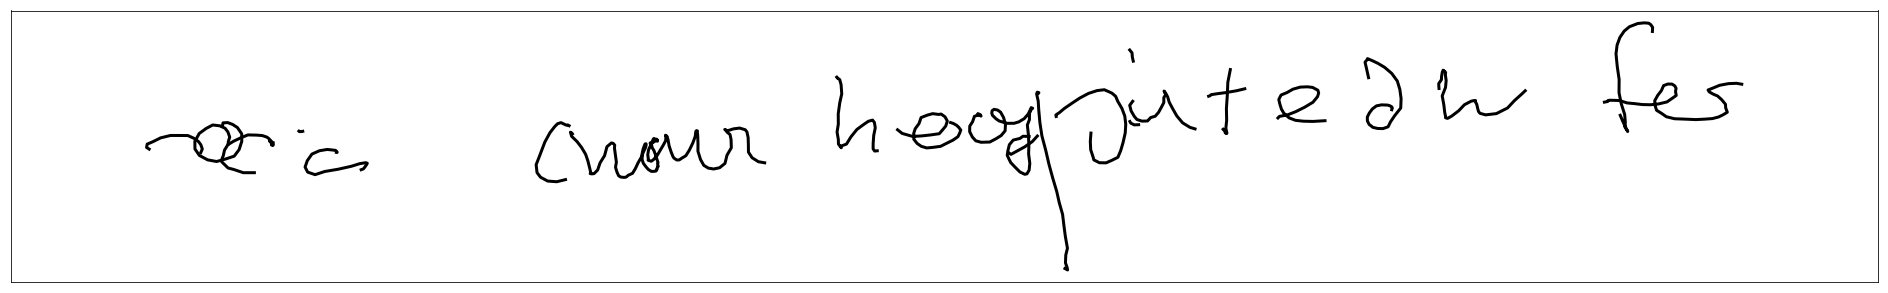

In [23]:
# test generation 80
s = generate_unconditionally(model, 700,4)
plot_stroke(s)

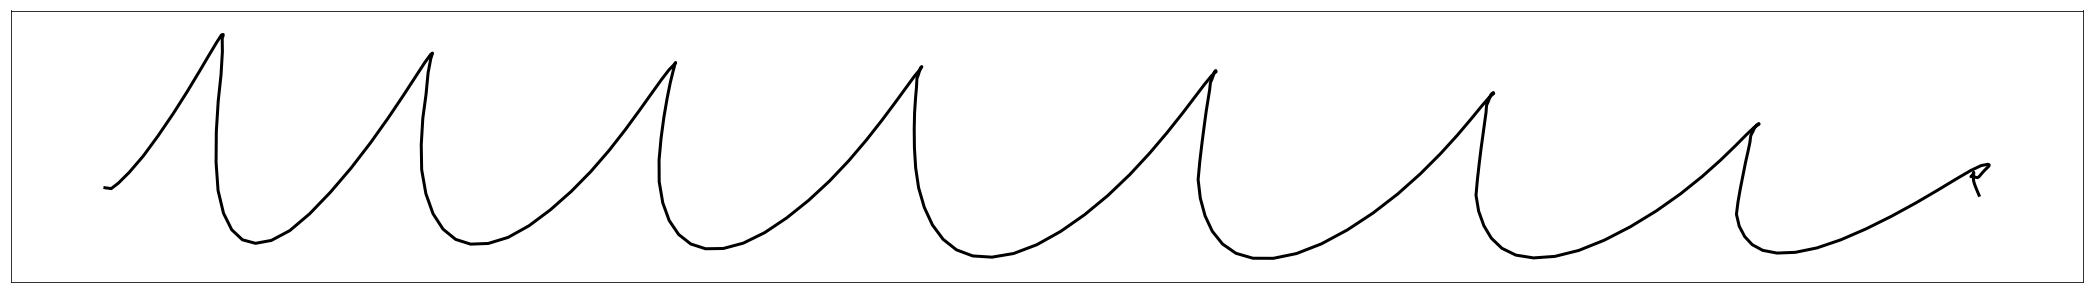

In [55]:
# test generation 80
g = greedy_generate()
g[650][0]=1
plot_stroke(g)

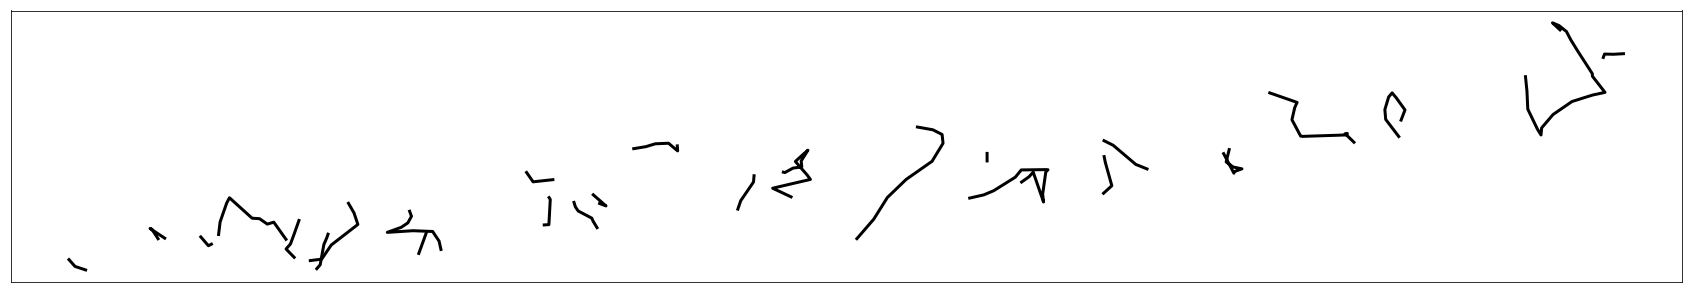

In [49]:
# test generation 60
s = generate_unconditionally(200,42)
plot_stroke(s)

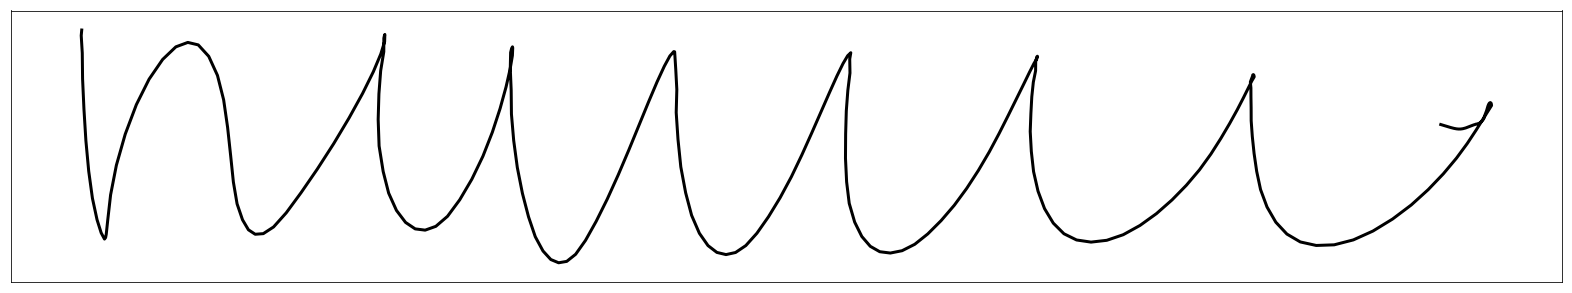

In [50]:
# test generation 60
g = greedy_generate()
g[650][0]=1
plot_stroke(g)

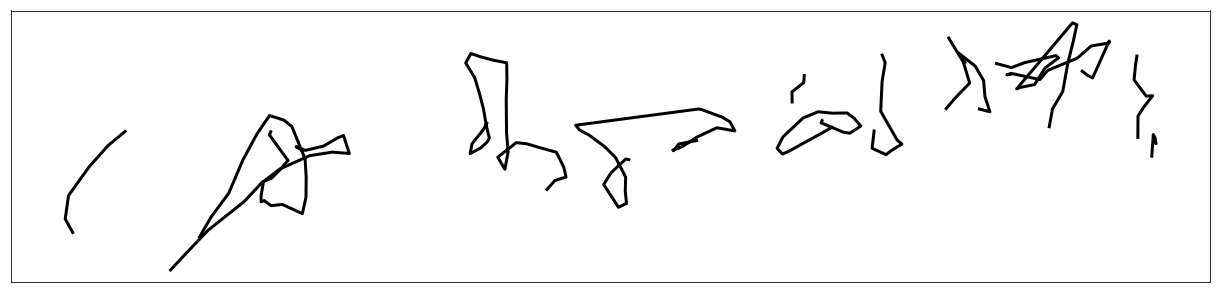

In [37]:
# test generation 30
s = generate_unconditionally(200,42)
plot_stroke(s)

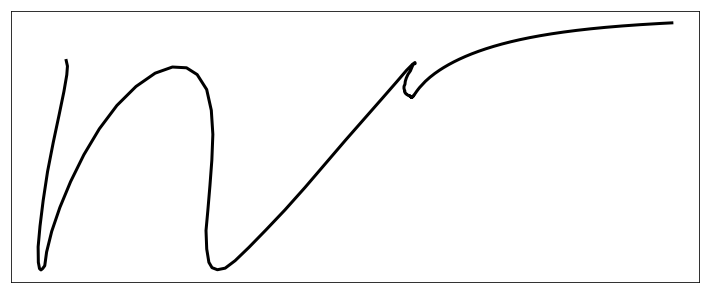

In [39]:
# test generation 30
g = greedy_generate()
g[650][0]=1
plot_stroke(g)
